In [57]:
import os
import re
import glob
import math
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, savgol_filter, convolve, peak_prominences
from peak_metrics import *
from utils import *

In [58]:
CSVs = []
for root, dirs, files in os.walk("Affinity Data"):
    for file in files:
        if file.endswith(".csv"):
             CSVs.append(os.path.join(root, file))

In [59]:
len(CSVs)

377

In [60]:
def show_peaks(name, uv_280, volume, peaks, half_width, contour_heights):
    plt.rcParams["figure.figsize"] = (20,10)
    # plt.plot(uv_280)
    # plt.plot(peaks, uv_280[peaks], "x")
    plt.plot(volume, uv_280)
    plt.plot(volume[peaks], uv_280[peaks], "x")
    #plt.plot(np.zeros_like(uv_280), "--", color="gray")
    plt.hlines(y=0, xmin=min(volume), xmax=max(volume), linestyle="dashed", color="gray" )
    plt.hlines(*half_width, color="C2")
    plt.vlines(x=volume[peaks], ymin=contour_heights, ymax=uv_280[peaks])
    plt.savefig(f'inspect_plots/{name}.png')
    plt.clf()

In [61]:
def query_line(volume, results):
    row_0 = [i for i in results[0]]
    row_1 = [volume[round(i)] for i in results[1]]
    row_2 = [volume[round(i)] for i in results[2]]
    return [row_0, row_1, row_2]

In [106]:
def get_elution_and_cip_idx(dataframe):

   #   if 'Elution' not in dataframe['Logbook'].values:
   #      #  print(dataframe['Logbook'].values)
   #       elution_idx = dataframe.index[dataframe['Logbook'] == 'Elution 1'].tolist()[-1]
   #   else:
   #      elution_idx = dataframe.index[dataframe['Logbook'] == 'Elution'].tolist()[-1]

   #   column_wash_idx = dataframe.index[dataframe['Logbook'] == 'Column Wash'].tolist()[-1]
    try:
        log_vals = dataframe['Logbook'].values

        if 'Column Wash' in dataframe['Logbook'].values:
            column_wash_idx = dataframe.index[dataframe['Logbook'] == 'Column Wash'].tolist()[-1]
        elif 'Column Wash 1' in dataframe['Logbook'].values:
            column_wash_idx = dataframe.index[dataframe['Logbook'] == 'Column Wash 2'].tolist()[-1]
        else:
            column_wash_idx = None

        if 'Column CIP' in dataframe['Logbook'].values:
            cip_idx = dataframe.index[dataframe['Logbook'] == 'Column CIP'].tolist()[-1]
        else:
            cip_idx = None
    except:
        column_wash_idx = None
        cip_idx = None
    #  cip_idx = dataframe.index[dataframe['Logbook'] == 'Column CIP'].tolist()[-1]
    return column_wash_idx, cip_idx


In [76]:
'Elution' in df['Logbook'].values

True

In [107]:
frame = {'file': [], 'Tailing Factor': [], 'Peak Assymetry': [], 'No. Theoretical Plates': [], 'Area (mAU*ml)':[]} #, 'Height':[]}

count = 0
errors = []
for csv in CSVs:
    name = csv.split('/')[-1][:-4]
    resin, serotype = get_resin_and_serotype(name)
    if resin == 'U':
        resin = get_resin(name)
    if serotype == 'U':
        serotype = csv.split('/')[1]
    # print(csv)
    try:
        df = pd.read_csv(csv, skiprows = [0,1], delimiter='\t', encoding='utf_16', on_bad_lines='skip', low_memory=False)
    except Exception as e:
        print(e, csv)

    try:
        # column_wash_idx = df.index[df['Logbook'] == 'Column Wash'].tolist()[-1]
        # cip_idx = df.index[df['Logbook'] == 'Column CIP'].tolist()[-1]

        column_wash_idx, cip_idx = get_elution_and_cip_idx(df)

        data = load_useful_data(df)

        if column_wash_idx != None and cip_idx != None:
            count += 1
            start_column_wash = df[data['Run Log']].loc[column_wash_idx].values[0]
            start_clean = df[data['Run Log']].loc[cip_idx].values[0]
        # start_elution = df[data['Run Log']].loc[elution_idx].values[0]
        # start_clean = df[data['Run Log']].loc[cip_idx].values[0]
            
            cols = df[data['UV_280']].columns
            volume = df[data['UV_280']][cols[0]]
            uv_280 = df[data['UV_280']][cols[1]]

            volume = volume.apply(lambda x: 0 if x < start_column_wash else x)
            volume = volume.apply(lambda x: 0 if x > start_clean else x)
            volume = volume.loc[volume > 0]

            uv_280 = uv_280[volume.index]
            uv_280  = uv_280.apply(lambda x: 0 if x < 0 else x)
            uv_280 = uv_280.loc[uv_280 > 0]
            uv_280.dropna(inplace=True)
            volume = volume.loc[uv_280.index]
            uv_280.reset_index(drop=True, inplace=True)
            volume.reset_index(drop=True, inplace=True)
            peaks, info = find_peaks(uv_280, height=10, width=15)
            results_half = peak_widths(uv_280, peaks, rel_height=0.5)
            results_full = peak_widths(uv_280, peaks, rel_height=1)
            results_five_pec = peak_widths(uv_280, peaks, rel_height=0.95)
            results_ten_pec = peak_widths(uv_280, peaks, rel_height=0.9)
            prominences = peak_prominences(uv_280, peaks)[0]
            contour_heights = uv_280[peaks] - prominences

            half_width = query_line(volume, results_half[1:])
            full_width = query_line(volume, results_full[1:])
            ten_percent_width = query_line(volume, results_ten_pec[1:])
            five_percent_width = query_line(volume, results_five_pec[1:])
            frame['file'].append(name)
            frame['Tailing Factor'].append(tailing_factor(peaks, results_five_pec[1:]))
            frame['Peak Assymetry'].append(peak_assymetry(peaks, results_ten_pec[1:]))
            frame['No. Theoretical Plates'].append(number_of_theoretical_plates(volume, peaks, results_half[1:]))
            frame['Area (mAU*ml)'].append(area(volume, peaks, results_full[1:], prominences))
            show_peaks(name, uv_280, volume, peaks, half_width, contour_heights)
    except Exception as e:
        print(e, csv)


    # try:
    #     peaks, info = find_peaks(uv_280, height=30, width=15)
    #     results_half = peak_widths(uv_280, peaks, rel_height=0.5)
    #     results_full = peak_widths(uv_280, peaks, rel_height=1)
    #     results_five_pec = peak_widths(uv_280, peaks, rel_height=0.95)
    #     results_ten_pec = peak_widths(uv_280, peaks, rel_height=0.9)
    #     prominences = peak_prominences(uv_280, peaks)[0]
    #     contour_heights = uv_280[peaks] - prominences

    #     half_width = query_line(volume, results_half[1:])
    #     full_width = query_line(volume, results_full[1:])
    #     ten_percent_width = query_line(volume, results_ten_pec[1:])
    #     five_percent_width = query_line(volume, results_five_pec[1:])
    # except Exception as e:
    #     print(e, csv)

    # try:
    #     frame['file'].append(name)
    #     frame['Tailing Factor'].append(tailing_factor(peaks, results_five_pec[1:]))
    #     frame['Peak Assymetry'].append(peak_assymetry(peaks, results_ten_pec[1:]))
    #     frame['No. Theoretical Plates'].append(number_of_theoretical_plates(volume, peaks, results_half[1:]))
    #     frame['Area (mAU*ml)'].append(area(volume, peaks, results_full[1:], prominences))
    # except Exception as e:
    #     print(e, csv)
    # try:
    #     # show_peaks(name, uv_280, volume, peaks, half_width, contour_heights)
    #     pass
    # except Exception as e:
    #     print(e, csv)
    



data = pd.DataFrame(frame)

'Logbook' is not in list Affinity Data/AAVX/AAVX 0.5ML Run SAS102122 004_fl.csv


In [101]:
data

,file,Tailing Factor,Peak Assymetry,No. Theoretical Plates,Area (mAU*ml)
0,AAVx method LG6 toyo Load 31.5 mL cycle 1 001,[1.9078325535911267],[1.9139187495697765],[883845.2203884664],[311.81650663129585]
1,AAVx method with LG6 Load 32 mL S2 cycle 8 001,"[0.7741096513858765, 2.155127381478092]","[0.510176140163623, 2.0035616120634843]","[1449215.8100415955, 1237472.3851519807]","[8.804774034811357, 475.8721219578665]"
2,AAVx method with LG6 Load cycle 3 001,"[1.7795590821954965, 2.3607665661673187]","[2.78399281697218, 2.461322488564957]","[994293.7782404291, 1304971.3446084908]","[3.8051112494186796, 519.3118442750689]"
3,AAVx method with LG6 Load 33 mL cycle 10 001,"[0.7522984155809617, 1.8128319629441247]","[0.45737381111838, 1.5519367922075795]","[2350562.012402722, 1152562.940864023]","[6.612635981924781, 460.0089500180139]"
4,AAVx method no LG6 Load 35 mL cycle 2 001,"[2.1902579481013706, 2.2967913131242503]","[3.5026834880070026, 2.2796865982988055]","[1609072.894572946, 1494595.1855151127]","[14.540886779762262, 517.7748497322888]"
...,...,...,...,...,...
355,AAVW8_AAV10 HEK lysate 003,[1.8836938861452295],[1.6511587404303973],[30651.530686190326],[891.1529719289896]
356,AAVA5_AAV10 HEK lysate 004,"[2.0805276815569305, 1.1706112348205886, 0.776...","[3.1838583748688074, 1.3457319010714262, 0.705...","[381410.1409734776, 2290399.011758907, 4181.48...","[0.0079673196221108, 0.001018456138749372, 3.5..."
357,AAVA1_AAV10 HEK lysate 001,[2.8891695447164043],[3.156758283915792],[27325.141152021086],[1204.0854254017677]
358,AAVA2_AAV10 HEK lysate 001,[2.369832121391846],[2.482770609536929],[39429.055037561535],[680.9330714370374]


In [104]:
csv = 'Affinity Data/AAVA3/New AAVA3/AAV1 Lysate - POROS AAVA3  pH 5.0 SAS081523 002.csv'
dat = pd.read_csv(csv, skiprows = [0,1], delimiter='\t', encoding='utf_16', on_bad_lines='skip', low_memory=False)

data = load_useful_data(dat)
data['Run Log']

def plot_data(data, data_dict, columns=['UV_280', 'Conductivity']):
    """
    This function takes in a dataframe and plots the data.
    Args:
        data: dataframe
        folder: folder to save the plots
        name: name of the plot
        data_dict: dictionary with useful data
        columns: list of columns to plot
    Returns:
        None"""
    plt.rcParams["figure.figsize"] = (20,10)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(data[data_dict[columns[0]][0]], data[data_dict[columns[0]][1]], 'g-', label=columns[0])
    ax2.plot(data[data_dict[columns[0]][0]], data[data_dict[columns[1]][1]], 'b-', label=columns[1]) 
    ax1.set_xlabel('Volume (ml)')
    ax1.set_ylabel('mAU', color='g')
    ax2.set_ylabel('mS/cm', color='b')
    # resin, serotype = get_resin_and_serotype(name)
    # plt.title(f'Resin: {resin}, Serotype: {serotype}')
    plt.legend()
    plt.xticks(np.arange(min(data[data_dict[columns[0]][0]]), max(data[data_dict[columns[0]][0]])+1, 15))
    plt.show()
    # fig.savefig(f'{folder}/plots/{name}.png')
    # fig.clf()
    # fig.clear()
    

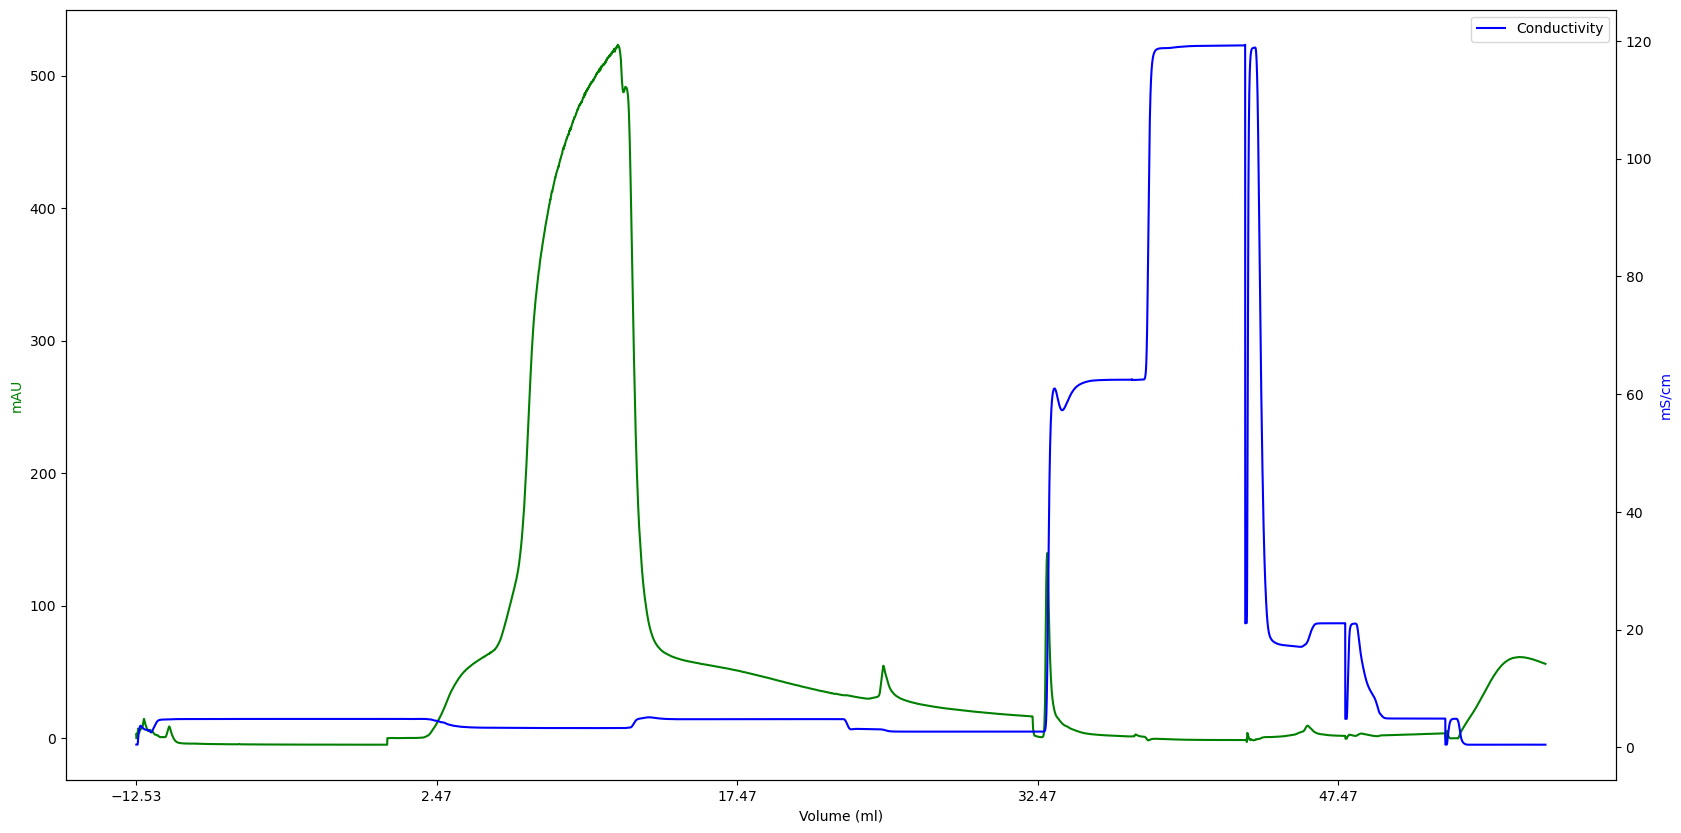

In [105]:
plot_data(dat, data)